In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pprint import pprint
import astropy.units as u
from astropy.units import Quantity

In [5]:
from gammapy.catalog import SourceCatalog3FGL, SourceCatalogObject3FGL

cat = SourceCatalog3FGL()

source = cat['Crab']
data = source.flux_points.table

# Flux units
data['dnde'] = data['dnde'].to('cm-2 s-1 MeV-1')

# Create flux error
dnde_err = data['dnde'] * (data['flux_errn'] / data['flux'])
data['dnde_err'] = dnde_err.to(data['dnde'].unit)

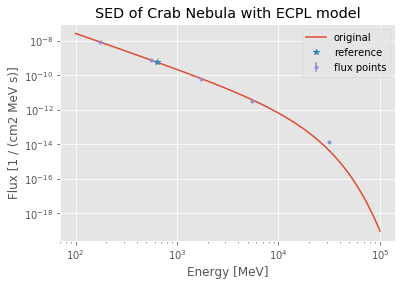

In [13]:
# Defining units
opts = dict(energy_unit='MeV', flux_unit='cm-2 s-1 MeV-1')

source.spectral_model.plot(source.energy_range, **opts)
# Spectral model used (PL, ECPL) based on the source's SpectrumType parameter

p = source.spectral_model.parameters

# Plot reference point
plt.plot(p['reference'].value, p['amplitude'].value, '*')

# Plot all data from source's FluxPoints
plt.errorbar(x=data['e_ref'],
             y = data['dnde'],
             yerr = data['dnde_err'],
             fmt='.'
            )

plt.title('SED of Crab Nebula with ECPL model')

plt.legend(['original', 'reference', 'flux points'])

# plt.savefig('sed_original.png')

In [14]:
print(source.spectral_model.parameters)

ParameterList
Parameter(name='index', value=2.045008659362793, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name='amplitude', value=5.541301861811121e-10, unit=Unit("1 / (cm2 MeV s)"), min=0, max=None, frozen=False)
Parameter(name='reference', value=635.5911254882812, unit=Unit("MeV"), min=None, max=None, frozen=0)
Parameter(name='ecut', value=8143.04345703125, unit=Unit("MeV"), min=None, max=None, frozen=False)

Covariance: 
[[  1.19075305e-04   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   7.13284136e-24   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.95372390e+05]]


In [15]:
# Defining an ECPL model (same as Gammapy's)
def dnde_model_ecpl(energy, amplitude, index, energy_cut, reference):
    return amplitude * (energy / reference) ** (-index) * np.exp((reference -energy) / energy_cut)

In [16]:
# Defining chi2 function for this source
def chi2(amplitude, index, energy_cut):
    
    dnde_model = dnde_model_ecpl(
        energy=data['e_ref'],
        amplitude=amplitude,
        index=index,
        energy_cut=energy_cut,
        reference=635.5911254882812 # <-- this is e_ref minus the units
    ) 

    chi = (data['dnde'] - dnde_model) / data['dnde_err']
    return np.sum(chi ** 2)

In [17]:
from iminuit import Minuit
import warnings
warnings.filterwarnings("ignore")

pars = dict(amplitude=5.541301861811121e-10, #amp value
            index=2.045008659362793,         #idx value
            energy_cut=8143.04345703125
            )

minuit = Minuit(chi2, **pars)

print("\n\nInitial parameters:\n")
minuit.print_initial_param()

print("\n\n\nOptimized parameters for best-fit model:")
minuit.migrad() # Performs the minimization



Initial parameters:



+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,5.5413e-10,1,0,0,,,
2,index,2.04501,1,0,0,,,
3,energy_cut,8143.04,1,0,0,,,





Optimized parameters for best-fit model:


FCN = 25.385480802185175 
 TOTAL NCALL = 70 
 NCALLS = 70 
 
 
 EDM = 0.0001270925005578926 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,5.52348e-10,2.83302e-12,0,0,,,
2,index,2.05489,0.00742392,0,0,,,
3,energy_cut,11364.8,556.848,0,0,,,


({'edm': 0.0001270925005578926, 'hesse_failed': False, 'fval': 25.385480802185175, 'has_made_posdef_covar': False, 'up': 1.0, 'is_valid': True, 'has_posdef_covar': True, 'has_valid_parameters': True, 'nfcn': 70, 'is_above_max_edm': False, 'has_covariance': True, 'has_accurate_covar': True, 'has_reached_call_limit': False},
 [{'name': 'amplitude', 'error': 2.833019554292477e-12, 'value': 5.523476620451121e-10, 'has_lower_limit': False, 'is_fixed': False, 'lower_limit': 0.0, 'has_upper_limit': False, 'upper_limit': 0.0, 'has_limits': False, 'is_const': False, 'number': 0},
  {'name': 'index', 'error': 0.0074239164158538965, 'value': 2.054894207237386, 'has_lower_limit': False, 'is_fixed': False, 'lower_limit': 0.0, 'has_upper_limit': False, 'upper_limit': 0.0, 'has_limits': False, 'is_const': False, 'number': 1},
  {'name': 'energy_cut', 'error': 556.8476727514419, 'value': 11364.796854643992, 'has_lower_limit': False, 'is_fixed': False, 'lower_limit': 0.0, 'has_upper_limit': False, 'upp

In [18]:
pprint(minuit.values)
pprint(minuit.errors)

{'amplitude': 5.523476620451121e-10,
 'energy_cut': 11364.796854643992,
 'index': 2.054894207237386}
{'amplitude': 2.833019554292477e-12,
 'energy_cut': 556.8476727514419,
 'index': 0.0074239164158538965}


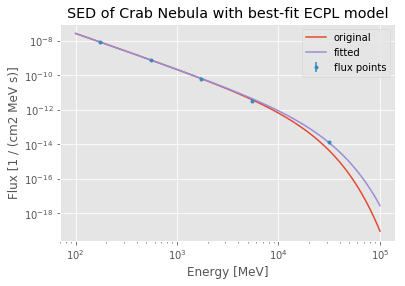

In [19]:
source.spectral_model.plot(source.energy_range, **opts)

plt.errorbar(x=data['e_ref'],
             y = data['dnde'],
             yerr = data['dnde_err'],
             fmt='.'
            )


from gammapy.utils.energy import Energy
energy = Energy.equal_log_spacing(
    emin=source.energy_range[0],
    emax=source.energy_range[1],
    nbins=100,
)


flux = source.spectral_model.evaluate(
    energy=energy.to('MeV').value,
    amplitude = minuit.values['amplitude'],
    index = minuit.values['index'],
    ecut = minuit.values['energy_cut'],
    reference=p['reference'].value,
)
plt.plot(energy, flux)

plt.title('SED of Crab Nebula with best-fit ECPL model')

plt.legend(['original', 'fitted', 'flux points'])

# plt.savefig('SED_fitted.png')